/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/lppls/lppls.py:31: RuntimeWarning: invalid value encountered in power
  return [np.power((tc - t), m) for t in time_series]
/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/lppls/lppls.py:35: RuntimeWarning: invalid value encountered in power
  return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in time_series]
/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/lppls/lppls.py:35: RuntimeWarning: invalid value encountered in log
  return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in time_series]
/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/lppls/lppls.py:41: RuntimeWarning: invalid value encountered in power
  return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) for t in time_series]
/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/lppls/lppls.py:41: RuntimeWarning: invalid value encountered in log
  return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) 

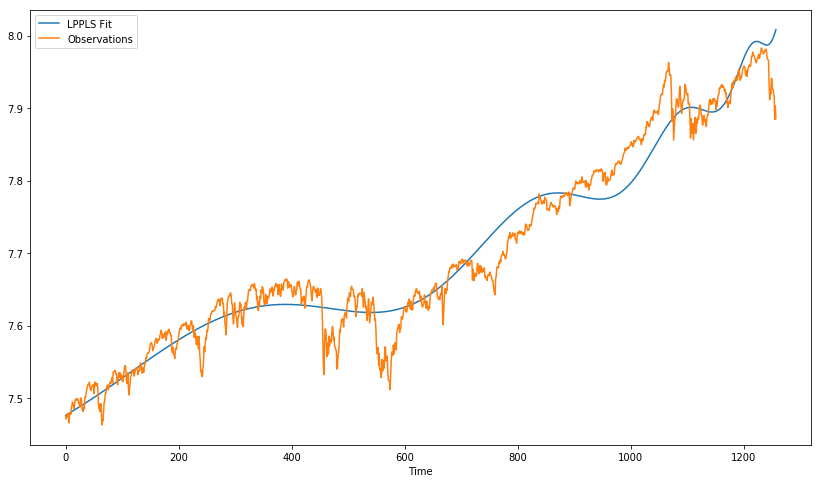

In [2]:
from lppls import lppls, data_loader
import numpy as np
import pandas as pd
%matplotlib inline

# read example dataset into df 
data = data_loader.sp500()

# convert index col to evenly spaced numbers over a specified interval
time = np.linspace(0, len(data)-1, len(data))

# create list of observation data, in this case, 
# daily adjusted close prices of the S&P 500
price = [p for p in data['Adj Close']]

# create Mx2 matrix (expected format for LPPLS observations)
observations = np.array([time, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the S&P 500 dataset
lppls_model = lppls.LPPLS(use_ln=True, observations=observations)

# fit the model to the data and get back the params
tc, m, w, a, b, c = lppls_model.fit(observations, MAX_SEARCHES, minimizer='Nelder-Mead')

# visualize the fit
lppls_model.plot_fit(observations, tc, m, w)


In [3]:
print(tc, m, w, a, b, c)


1333.6963257362281 0.36861876689715367 8.796029740890003 8.293694861650426 -0.05552294397585483 0.0032314602342929464


/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/huaichunshih/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


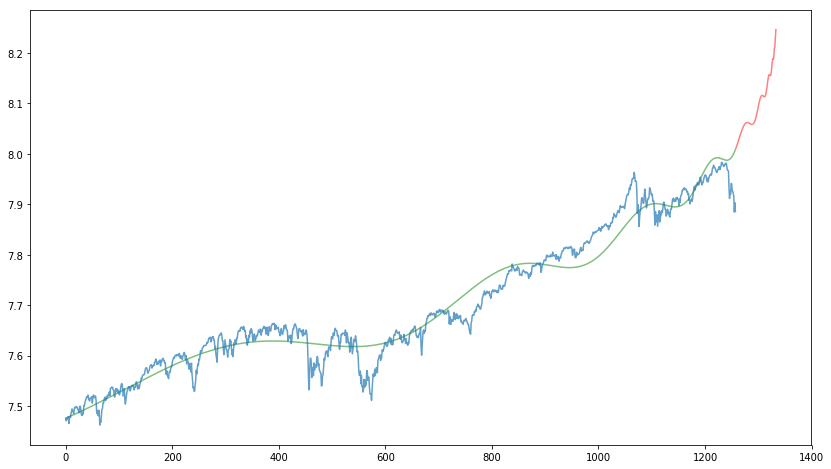

In [86]:
import matplotlib.pyplot as plt

def plot_predic(observations, lppls_model, tc, m, w):
        """
        Args:
            tc (float): predicted critical time
            m (float): predicted degree of super-exponential growth
            w (float): predicted scaling ratio of the temporal hierarchy of oscillations
            observations (Mx2 numpy array): the observed data
        Returns:
            nothing, should plot the fit
        """
        lin_vals = lppls_model.matrix_equation(observations, tc, m, w)

        a = float(lin_vals[0])
        b = float(lin_vals[1])
        c1 = float(lin_vals[2])
        c2 = float(lin_vals[3])
        window_predic = [float(t) for t in range(int(observations[0][-1])+1, int(tc)+1)]
        lppls_fit = [lppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in observations[0]]
        lppls_predic = [lppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in window_predic]
        original_observations = np.log(observations[1]) if lppls_model.use_ln else observations[1]

        data = pd.DataFrame({
            'Time': observations[0],
            #'LPPLS Fit': lppls_fit,
            'Observations': original_observations,
        })
        data = data.set_index('Time')
        
        plt.figure(figsize=(14, 8))
        plt.hold(True)
        #print([i for i in range(0, len(lppls_fit))])
        T = [i for i in range(300, len(lppls_fit)+300)]
        plt.plot(observations[0], lppls_fit, color='green', alpha=0.5)
        plt.plot(window_predic, lppls_predic, color='red', alpha=0.5)
        plt.plot(observations[0],original_observations, alpha=0.7)
        #data.plot(figsize=(14, 8))

#lin_vals = lppls_model.matrix_equation(observations, tc, m, w)
plot_predic(observations, lppls_model, tc, m, w)

In [150]:
import math

def isWarning(t1, t2, m, w, tc, b, c1, c2):
    dt = t2 - t1
    oscillations = (w/2)*math.log(abs((tc+1000 - t1)/dt))
    c = math.sqrt(c1**2+c2**2)
    damping = (m*abs(b))/(w*abs(c)) 
    print(m, w, tc, oscillations, damping)
    CD = [0.01 <= m <= 1.2,
                2 <= w <= 25,
                t2-0.05*dt <= tc <= t2+0.1*dt,
                oscillations >= 2.5,
                damping >= 0]
    print(CD)
    print('dt', dt, 'tc - t1', tc - t1)
    print('w',w)
    return all([0.01 <= m <= 1.2,
                2 <= w <= 25,
                t2-0.05*dt <= tc <= t2+0.1*dt,
                oscillations >= 2.5,
                damping >= 0])

In [151]:
lin_vals = lppls_model.matrix_equation(observations, tc, m, w)
a, b, c1, c2 = np.squeeze(np.asarray(lin_vals))
#print(lin_vals, b)
t1, t2 = observations[0][0], observations[0][-1]

isWarning(t1, t2, m, w, tc, b, c1, c2)

0.36861876689715367 8.796029740890003 1333.6963257362281 2.7211638918996908 0.720052930837167
[True, True, True, True, True]
dt 1257.0 tc - t1 1333.6963257362281
w 8.796029740890003


True

In [29]:
x = np.append(observations[0],[range(8,10)])
x

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.257e+03, 8.000e+00,
       9.000e+00])

In [89]:
all(True, True, False])

False